### Preprocesamiento: GeoHash, outliers, categorización y feature engineering.

Resumen:

- Geohash: Método de categorización para coordenadas.
- Procesamiento de Outliers.
- Feature Engineering:
    - Distritos con más ingresos (Pitucos)
    - Precio por m2 por Geohash <- **VARIABLE IMPORTANTE***
    - Clustering de Geohashes.
    - Variable de áreas ponderadas (D = Area_total*W1 + Area_constr*W2)
   


*Los precios por m2 por Geohash pueden ser un proxy de qué tan valioso es una zona (cuadra, barrio). Para inferir el valor real del metro cuadrado por distrito o zona esto sería muy útil.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geohash2 as gh

import warnings
import gc
warnings.filterwarnings('ignore') #Para que no me salgan caveats
gc.collect() #Como garbage cleaner
pd.set_option('display.max_columns',None) #Para ver todas mis columnas...

In [2]:
df = pd.read_csv('../data/Notebook02_output_data.csv')
df.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1,inplace=True)

In [3]:
df.drop(df[df.Precio > df.Precio.quantile(.99)].index, axis=0,inplace=True)

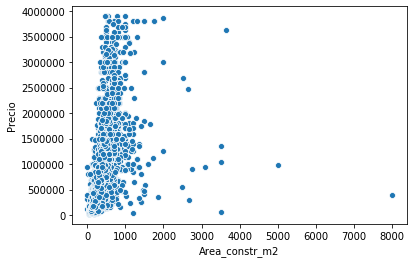

In [4]:
plt.ticklabel_format(style='plain', axis='y')
sns.scatterplot(x='Area_constr_m2',y='Precio',data=df)

#Igual se cumpliría el precio por metro cuadrado?

In [5]:
# Podemos dropear también los outliers 
index_to_drop_outlier = df[df.Area_constr_m2 > 1900].index

In [6]:
df.drop(index_to_drop_outlier,axis=0,inplace=True)

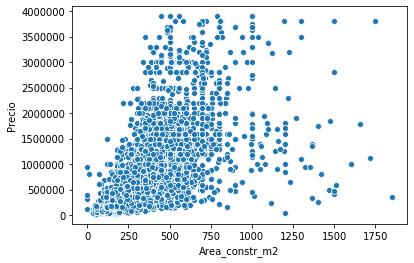

In [7]:
plt.ticklabel_format(style='plain', axis='y')
sns.scatterplot(x='Area_constr_m2',y='Precio',data=df)

#Igual se cumpliría el precio por metro cuadrado?

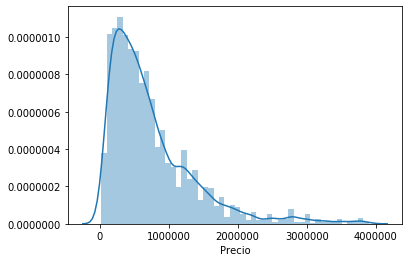

In [8]:
sns.distplot(df['Precio'])

In [10]:
df_gh = df[['longitud','latitud']]
df_gh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7573 entries, 0 to 7662
Data columns (total 2 columns):
longitud    7573 non-null float64
latitud     7573 non-null float64
dtypes: float64(2)
memory usage: 177.5 KB


#### Geohashing

In [12]:
df_gh.drop(df_gh[df_gh.longitud.isna()].index, axis=0,inplace=True)

In [13]:
df_gh['geohash'] = df_gh.apply(lambda x: gh.encode(x.latitud,x.longitud,precision=6), axis = 1)
df_gh.head()

longitud    latitud geohash
0 -76.929494 -12.077232  6mc733
1 -76.872657 -12.005022  6mc7dw
2 -76.910620 -12.065150  6mc73g
3 -76.526003 -12.841678  6m9wfw
4 -76.972217 -12.113779  6mc706

In [14]:
df['geohash_grado6'] = df_gh.apply(lambda x: gh.encode(x.latitud,x.longitud,precision=6),axis=1)
df['geohash_grado5'] = df_gh.apply(lambda x: gh.encode(x.latitud,x.longitud,precision=5),axis=1)
df['geohash_grado7'] = df_gh.apply(lambda x: gh.encode(x.latitud,x.longitud,precision=7),axis=1)
df['geohash_grado8'] = df_gh.apply(lambda x: gh.encode(x.latitud,x.longitud,precision=8),axis=1)

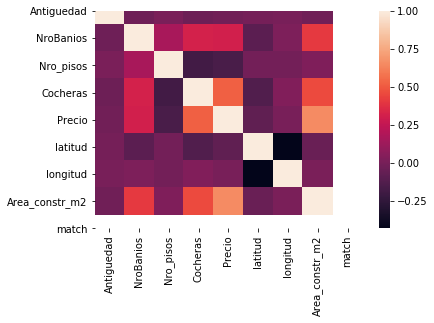

In [15]:
sns.heatmap(df.corr())

In [16]:
df.head()

Antiguedad              Anunciante  Balneario  NroBanios  Nro_pisos  \
0         5.0  Valentinoinmobiliaria        Nulo        4.0        2.0   
1         5.0           No disponible       Nulo        5.0        3.0   
2         3.0           No disponible       Nulo        5.0        3.0   
3         1.0           No disponible  Sol Y Mar        5.0        2.0   
4         4.0           No disponible       Nulo        4.0        2.0   

   Cocheras                                        Descripcion  \
0       3.0   excelente opcion para vivir en una de las mej...   
1       1.0   hermosa casa a espalda de futura avenida prol...   
2       4.0   casa de estreno acabados de primera. calle ce...   
3       3.0   linda casa en condominio con piscina club hou...   
4       2.0   monterrico 2 casas en 1 ( casa bajos 4 dormit...   

                                           Direccion Dormitorios  \
0  Malecon Monte Bello 5 La Molina, La Planicie, ...           3   
1  Mz. O2 Lt. 03 Urb. San Antonio De Carapongo 2 ...          5+   
2  El Pinar 120 , La Planicie 1era Etapa La Molin...           4   
3  Km 98.5 De La Panamericana Sur Asia, Sol Y Mar...           4   
4  Mariano De Rivera Y Ustariz #215 Surco, Huerto...          5+   

  Estado de Inmueble              Fecha_pub   Luminosidad Mascotas     Precio  \
0          Excelente  Publicado el 19.09.19  Muy luminoso       Si   885000.0   
1          Excelente  Publicado el 28.08.19  Muy luminoso       Si   150000.0   
2          Excelente  Publicado el 06.08.19  Muy luminoso       Si  1950000.0   
3          Excelente  Publicado el 25.08.19  Muy luminoso       Si   380000.0   
4          Muy bueno  Publicado el 14.08.19  Muy luminoso       Si   590000.0   

            Tipo   TipoCochera             Ubicacion Uso_comercial  \
0           Casa     Paralelas         LaMolina-Lima            No   
1           Casa  NoEspecifica       Lurigancho-Lima            Si   
2           Casa     Paralelas         LaMolina-Lima  NoEspecifica   
3  Casa de Playa     Paralelas             Asia-Lima  NoEspecifica   
4           Casa      Lineales  SantiagoDeSurco-Lima  NoEspecifica   

  Uso_profesional    latitud   longitud Area_constr  Area_total  \
0    NoEspecifica -12.077232 -76.929494   450.00 m2   600.00 m2   
1              Si -12.005022 -76.872657   350.00 m2   183.00 m2   
2    NoEspecifica -12.065150 -76.910620   625.00 m2  1518.00 m2   
3    NoEspecifica -12.841678 -76.526003   150.00 m2   150.00 m2   
4    NoEspecifica -12.113779 -76.972217   290.00 m2   344.00 m2   

   Area_constr_m2 Area_total_m2  match 'Cuarto de servicio' 'Deposito'  \
0           450.0         600.0      0                  1.0        1.0   
1           350.0         183.0      0                  1.0        1.0   
2           625.0        1518.0      0                  1.0        0.0   
3           150.0         150.0      0                  0.0        1.0   
4           290.0         344.0      0                  1.0        0.0   

  'Terraza' 'Kitchenette' 'Sala de estar' 'Sotano' 'Patio' 'anx81tico'  \
0       0.0           0.0             0.0      0.0     0.0         1.0   
1       0.0           0.0             0.0      0.0     0.0         0.0   
2       0.0           0.0             0.0      0.0     0.0         0.0   
3       0.0           0.0             0.0      0.0     0.0         0.0   
4       1.0           0.0             1.0      0.0     1.0         0.0   

  'Comedor diario' 'Comedor' 'Banio de servicio' 'Jardanxadn Interno'  \
0              1.0       1.0                 1.0                  0.0   
1              1.0       1.0                 1.0                  0.0   
2              1.0       1.0                 1.0                  0.0   
3              0.0       1.0                 1.0                  0.0   
4              0.0       1.0                 1.0                  1.0   

  'Walking Closet' 'Escritorio' 'Cocina' 'Banio independiente'  \
0              0.0          0.0      1.0      

### Feature Engineering

- Sacar Precio de metro cuadrado por Distrito, por geohash? Por geohash no por el problema de imputacion. **LISTO**

- Hacer precio por metro cuadrado para usarlo como target después y evaluar las dos métricas. **LISTO**

- Clusterizar longitudes y latitudes **CAVEAT**

- Crear un feature de escala de pituquería. Agrupar distritos y categorizarlos. **LISTO**

- Hacer una variable siguiendo (D = Area_total*W1 + Area_constr*W2) donde 

W1=(Corr(Area_total|Precio)/(Corr(Area_total|Precio)+Corr(Area_constr|Precio))

W2 = (Corr(Area_constr|Precio)/(Corr(Area_total|Precio)+Corr(Area_constr|Precio))

In [17]:
df.drop(df[df.Area_total_m2 == 'NoEspecifica'].index,axis=0,inplace=True)

In [18]:
df.Area_total_m2 = df.Area_total_m2.astype('float64')

In [19]:
#El POSIBLE TARGET PUEDE SER ESTE.

df['preciom2_area_total'] = df.Precio / df.Area_total_m2
df['preciom2_area_constr'] = df.Precio / df.Area_constr_m2

In [20]:
dist_ = df.groupby('Distrito')['preciom2_area_total','preciom2_area_constr'].agg('mean')
df = df.merge(dist_, on='Distrito', how='left')

In [21]:
dist_[dist_.index == 'Lurigancho']

preciom2_area_total  preciom2_area_constr
Distrito                                             
Lurigancho           865.087557           1310.324435

In [22]:
df.drop(['preciom2_area_total_x','preciom2_area_constr_x'],axis=1,inplace=True)

In [23]:
df = df.rename(columns = {'preciom2_area_total_y':'preciom2_area_total',
                     'preciom2_area_constr_y':'preciom2_area_constr'})

Cluster de logitud y latitud.

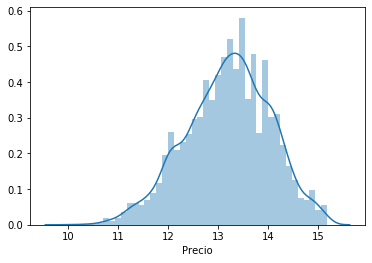

In [24]:
sns.distplot(np.log1p(df.Precio))

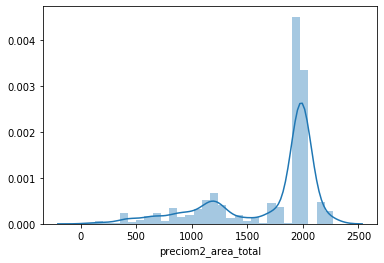

In [25]:
sns.distplot(df.loc[(df['preciom2_area_total'] < df['preciom2_area_total'].quantile(.94)),'preciom2_area_total'])

In [26]:
df['preciom2_area_total'].mean()

1820.0863151291928

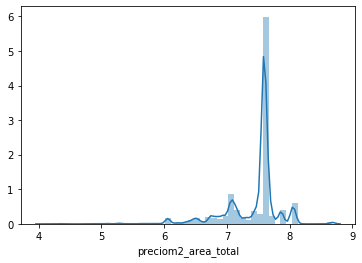

In [27]:
sns.distplot(np.log1p(df['preciom2_area_total']))

Agrupando distritos

In [28]:
pitucos = ['LaMolina','Asia','SantiagoDeSurco','SanBorja','Miraflores','SanIsidro','Barranco','SanBartolo',
           'Mancora']
cuasi_pitucos = ['Lince','JesusMaria','SanMiguel','Chaclacayo','Brenia','Ate','LaPerla']

In [30]:
df['grupo_dist'] = 'No_es_pituco'
df.loc[df['Distrito'].isin(pitucos),'grupo_dist'] = 'Es_pituco'
df.loc[df['Distrito'].isin(cuasi_pitucos),'grupo_dist'] = 'Es_cuasi_pituco'

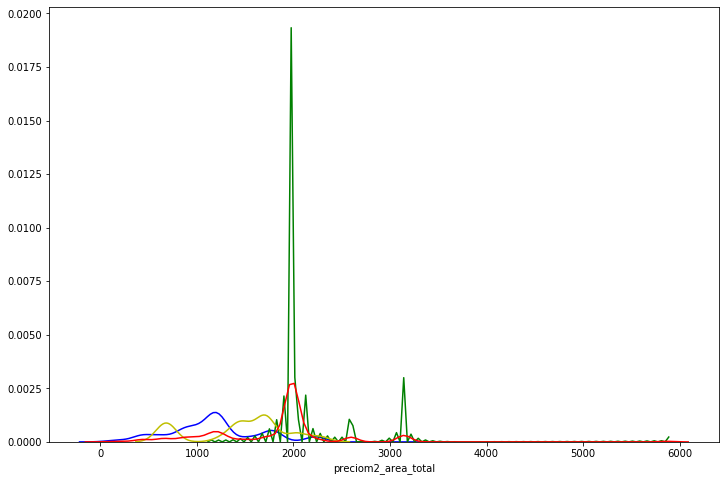

In [31]:
#Categorizacion de "pituquería"

target_0 = df.loc[df['grupo_dist'] == 'No_es_pituco']
target_1 = df.loc[df['grupo_dist'] == 'Es_pituco']
target_2 = df.loc[df['grupo_dist'] == 'Es_cuasi_pituco']

plt.figure(figsize=(12,8))
sns.distplot(target_0[['preciom2_area_total']], hist=False,color="b")
sns.distplot(target_1[['preciom2_area_total']], hist=False,color="g")
sns.distplot(target_2[['preciom2_area_total']], hist=False,color="y")
sns.distplot(df['preciom2_area_total'],hist=False,color="r")
plt.show()

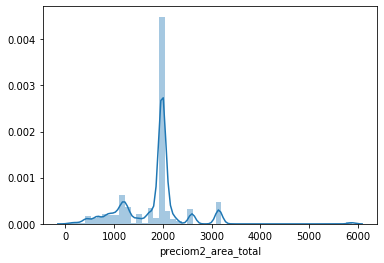

In [32]:
sns.distplot(df['preciom2_area_total'])

-

In [33]:
#Calculo de correlaciones
from scipy.stats import pearsonr

corr_at,at = pearsonr(df['Area_total_m2'],df['preciom2_area_total'])
corr_ac,ac = pearsonr(df['Area_constr_m2'],df['preciom2_area_total']) 
print(corr_at, corr_ac)

#Calculo de w_at y w2_ac
w_at = corr_at/(corr_at + corr_ac)
w_ac = corr_ac/(corr_at + corr_ac)
print(w_at, w_ac)

#Añadiendo el feature area_ponderada 
df['area_ponderada'] = (df['Area_total_m2']*w_at)+(df['Area_constr_m2']*w_ac)
df.area_ponderada.head()

-0.21623087836855603 0.14635206236033835
3.0943695202724597 -2.0943695202724597


0     914.155428
1    -166.759710
2    3388.271982
3     150.000000
4     457.095954
Name: area_ponderada, dtype: float64

In [34]:
df.to_csv('.../data/Notebook03_output_data.csv')